<h1 style="text-align:center">A star</h1>

En este notebook implementaremos $\text{A}^*$, queremos comparar una heurística admisible trivial con $\text{LoHA}^*$. También implementaremos Dijkstra para realizar comparaciones. Para hacer esto más didáctico, utilizaremos la librería de Open Street Map `osmnx` para cargar el grafo de Bogotá, así mismo, implementaremos funciones para obtener visualizaciones útiles.

### Carga de librerías

In [1]:
import math
import random
import heapq
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt

### Carga del grafo

El grafo asociado a Bogotá tiene el nombre de "*Bogotá Distrito Capital - Municipio*" interno en la librería:

In [2]:
place_name = "Bogotá Distrito Capital - Municipio"
G = ox.graph_from_place(place_name, network_type="drive")

Veamos el número de nodos ($n$) y el de aristas ($m$):

In [3]:
basic_stats = ox.stats.basic_stats(G)
stats = {key: basic_stats[key] for key in ['n', 'm']}
pd.DataFrame.from_dict(stats, orient='index')

,0
n,61598
m,154054


Por defecto este grafo cuenta con varios atributos para cada nodo y cada arista. En el caso de los nodos, trae los valores de su longitud ($x$), latitud ($y$) y el número de calles que cruzan ese nodo (*street_count*):

In [4]:
G.nodes.get(list(G.nodes)[0]).keys()

dict_keys(['y', 'x', 'street_count'])

En el caso de las aristas, algunos atributos que nos interesan son su longitud (*length*) dada en metros y su velocidad de tránsito máxima (*maxspeed*) dada en kilómetros por hora (en general).

In [5]:
edge_attributes = ox.graph_to_gdfs(G, nodes=False).columns
print(edge_attributes)

Index(['osmid', 'highway', 'lanes', 'name', 'oneway', 'reversed', 'length',
       'geometry', 'maxspeed', 'junction', 'access', 'bridge', 'ref', 'width',
       'tunnel', 'area'],
      dtype='object')


Visualicemos el grafo:

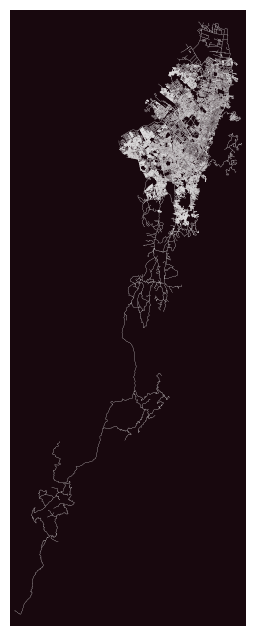

In [6]:
ox.plot.plot_graph(G, bgcolor="#18080e", edge_color="w", edge_linewidth=0.1, node_size=0,);

Como vemos, hay algunos nodos muy al sur de la ciudad que son incluidos, nos concentraremos en un subgrafo más centrado en la parte urbana de la ciudad (filtrado por latitud y longitud):

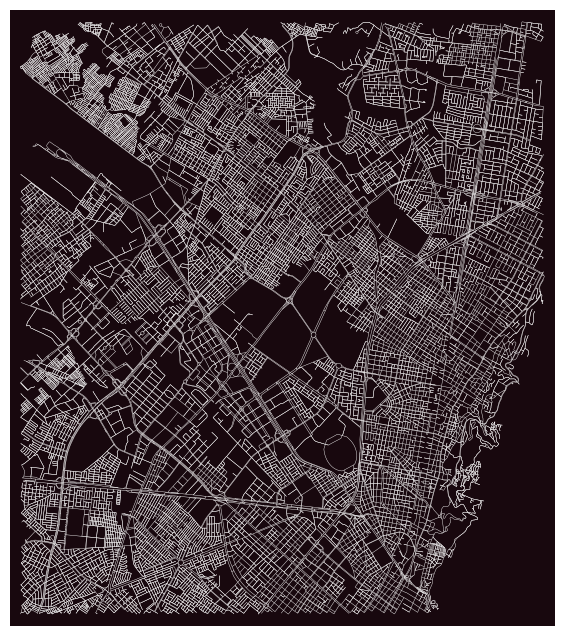

In [7]:
def truncateGraph(G, north=None, south=None, west=None, east=None):
    nodes_to_remove = []

    for node, data in G.nodes(data=True):
        if (north is not None and data['y'] > north) or \
           (south is not None and data['y'] < south) or \
           (east is not None and data['x'] > east) or \
           (west is not None and data['x'] < west):
            nodes_to_remove.append(node)

    G.remove_nodes_from(nodes_to_remove)
    return G 
 
G = truncateGraph(G, west=-74.14604, east = -74.04347, south = 4.60491, north=4.72049)
ox.plot.plot_graph(G, bgcolor="#18080e", edge_color="w", edge_linewidth=0.3, node_size=0);

### Limpieza del grafo

El valor del atributo *maxspeed* de cada arista puede no existir (`None`), puede estar en tipo *string* o puede ser una lista con varios valores. A continuación, arreglamos este inconveniente e incluimos el atributo `weight` que representará el tiempo que se toma en recorrer una arista (distancia sobre velocidad):

In [8]:
for edge in G.edges:
    # Cleaning the "maxspeed" attribute, some values are lists, some are strings, some are None
    maxspeed = 40
    if "maxspeed" in G.edges[edge]:
        maxspeed = G.edges[edge]["maxspeed"]
        if type(maxspeed) == list:
            speeds = [ int(speed) for speed in maxspeed ]
            maxspeed = min(speeds)
        elif type(maxspeed) == str:
            maxspeed = int(maxspeed)
    G.edges[edge]["maxspeed"] = maxspeed
    # Adding the "weight" attribute (time = distance / speed)
    G.edges[edge]["weight"] = (G.edges[edge]["length"] / 1000) / maxspeed

### Funciones para visualizar

In [9]:
def style_unvisited_edge(edge):
    G.edges[edge]["color"] = "#fa001d"
    G.edges[edge]["alpha"] = 0.2
    G.edges[edge]["linewidth"] = 0.5

def style_visited_edge(edge):
    G.edges[edge]["color"] = "#fa001d"
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

def style_active_edge(edge):
    G.edges[edge]["color"] = '#ffbfb8'
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

def style_path_edge(edge):
    G.edges[edge]["color"] = "white"
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

In [10]:
def plot_graph(step=None, algorithm=None):
    if step is None:
        ox.plot_graph(
            G,
            node_size =  [ G.nodes[node]["size"] for node in G.nodes ],
            edge_color = [ G.edges[edge]["color"] for edge in G.edges ],
            edge_alpha = [ G.edges[edge]["alpha"] for edge in G.edges ],
            edge_linewidth = [ G.edges[edge]["linewidth"] for edge in G.edges ],
            node_color = "white",
            bgcolor = "#18080e",
        )
    else:
        fig, ax = ox.plot_graph(
                G,
                node_size =  [ G.nodes[node]["size"] for node in G.nodes ],
                edge_color = [ G.edges[edge]["color"] for edge in G.edges ],
                edge_alpha = [ G.edges[edge]["alpha"] for edge in G.edges ],
                edge_linewidth = [ G.edges[edge]["linewidth"] for edge in G.edges ],
                node_color = "white",
                bgcolor = "#18080e",
                filepath = f"./frames_{algorithm}/{step:05d}.png",
                save = True,
                show = False, 
                close = False
            )
        plt.close(fig)

In [11]:
def plot_heatmap(algorithm):
    edge_colors = ox.plot.get_edge_colors_by_attr(G, f"{algorithm}_uses", cmap="hot")
    fig, _ = ox.plot_graph(
        G,
        node_size = 0,
        edge_color = edge_colors,
        bgcolor = "#18080e"
    )

### Implementación de algoritmos

Recordemos el algoritmo de $A^*$:

**Entrada:**  
- Grafo/nodos con conexiones  
- Nodo inicial `start`  
- Nodo objetivo `goal`  
- Función heurística `h(n)`

**Salida:**  
- Camino óptimo o falla

1. **Inicializar:**  
   - Abrir lista `open_set = {start}`  
   - Cerrado lista `closed_set = {}`  
   - `g_score[n] = ∞` para todos los nodos, `g_score[start] = 0`  
   - `f_score[n] = ∞` para todos los nodos, `f_score[start] = h(start)`

2. **Mientras** `open_set` no esté vacío:  
   a. Seleccionar nodo `current` en `open_set` con menor `f_score`  
   b. **Si** `current == goal`:  
      - Reconstruir camino y retornarlo  
      
   c. Remover `current` de `open_set`, agregar a `closed_set`  
   d. **Para cada** vecino `neighbor` de `current`:  
      - i. **Si** `neighbor` en `closed_set`: saltar  
      - ii. Calcular `tentative_g = g_score[current] + costo(current, neighbor)`  
      - iii. **Si** `tentative_g < g_score[neighbor]`:  
          - Actualizar `previous[neighbor] = current`  
          - `g_score[neighbor] = tentative_g`  
          - `f_score[neighbor] = g_score[neighbor] + h(neighbor)`  
          - **Si** `neighbor` no en `open_set`:  
              - Agregar `neighbor` a `open_set`

3. **Retornar** falla (no hay camino)

A continuación implementamos el algoritmo:

In [12]:
def a_star(start, goal, heuristic, plot=False, save_frames=False):
    ######## Para visualización #############
    for edge in G.edges: 
        style_unvisited_edge(edge)
    for node in G.nodes:
        G.nodes[node]["size"] = 0
    G.nodes[start]["size"] = 50
    G.nodes[goal]["size"] = 50
    #########################################

    for node in G.nodes:
        G.nodes[node]["visited"] = False
        G.nodes[node]["previous"] = None
        G.nodes[node]["g_score"] = float("inf")
        G.nodes[node]["f_score"] = float("inf")

    step = 0
    G.nodes[start]["g_score"] = 0
    G.nodes[start]["f_score"] = heuristic(start, goal)
    
    pq = [(G.nodes[start]["f_score"], start)]
    while pq:
        _, node = heapq.heappop(pq)

        if node == goal:
            if plot:
                print("Iteraciones:", step)
                plot_graph()
            return
        
        if G.nodes[node]["visited"]: 
            continue
        G.nodes[node]["visited"] = True
        
        for edge in G.out_edges(node):
            ######## Para visualización #############
            style_visited_edge((edge[0], edge[1], 0))
            #########################################

            neighbor = edge[1]
            tentative_g_score = G.nodes[node]["g_score"] + G.edges[(edge[0], edge[1], 0)]["weight"] # g_score[current] + costo(current, neighbor)`  
            if tentative_g_score < G.nodes[neighbor]["g_score"]:
                G.nodes[neighbor]["previous"] = node
                G.nodes[neighbor]["g_score"] = tentative_g_score
                G.nodes[neighbor]["f_score"] = tentative_g_score + heuristic(neighbor, goal)
                heapq.heappush(pq, (G.nodes[neighbor]["f_score"], neighbor))

                ######## Para visualización #############
                for edge2 in G.out_edges(neighbor):
                    style_active_edge((edge2[0], edge2[1], 0))
                #########################################

        ######## Para visualización #############
        if save_frames: 
            plot_graph(step=step, algorithm="a_star")
        step += 1
        #########################################

Como los pesos que estamos considerando son de tiempo (horas), consideraremos la siguiente heurística que divide la distancia de los puntos entre la velocidad máxima ($60$ kilómetros por hora para el caso del grafo de Bogotá):

In [13]:
def haversine_time(node1, node2):
    # Obtener latitudes y longitudes en radianes
    lat1, lon1 = math.radians(G.nodes[node1]["y"]), math.radians(G.nodes[node1]["x"])
    lat2, lon2 = math.radians(G.nodes[node2]["y"]), math.radians(G.nodes[node2]["x"])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    R = 6378  # Radio de la Tierra en km
    distance_k = float(R * c)
    max_speed=60
    return (distance_k / max_speed)

Adicionalmente, implementamos una función para reconstruir el camino encontrado:

In [14]:
def reconstruct_path(start, goal, algorithm=None, plot=False, save_frames=False):
    ######## Para visualización #############
    algorithm += "_path"
    for edge in G.edges:
        style_unvisited_edge(edge)
    #########################################

    dist, step, total_time = 0, 0, 0
    speeds = []
    curr = goal
    while curr != start:
        prev = G.nodes[curr]["previous"]
        dist += G.edges[(prev, curr, 0)]["length"]
        speeds.append(G.edges[(prev, curr, 0)]["maxspeed"])
        total_time += ((G.edges[(prev, curr, 0)]["length"] / 1000) / G.edges[(prev, curr, 0)]["maxspeed"])
        
        ######## Para visualización ############# 
        style_path_edge((prev, curr, 0))
        if save_frames:
            plot_graph(step=step, algorithm=algorithm)
        if algorithm:
            G.edges[(prev, curr, 0)][f"{algorithm}_uses"] = G.edges[(prev, curr, 0)].get(f"{algorithm}_uses", 0) + 1
        #########################################
        
        curr = prev
        step += 1

    ######## Para visualización #############     
    if plot:
        print(f"Distance: {dist / 1000}km")
        print(f"Avg. speed: {sum(speeds)/len(speeds)}km/h")
        # print(f"Total time: {dist/(sum(speeds)/len(speeds)) * 60}")
        print(f"Total time: {total_time * 60}min")
        plot_graph()
    #########################################

### Aplicación

Elegimos dos nodos al azar:

In [15]:
random.seed(47) # Para reproducir resultados
start = random.choice(list(G.nodes))
goal = random.choice(list(G.nodes))

#### Dijkstra

Encontremos la solución óptima (garantizada) usando Dijkstra ($A^*$) con heurística $0$:

Iteraciones: 5759


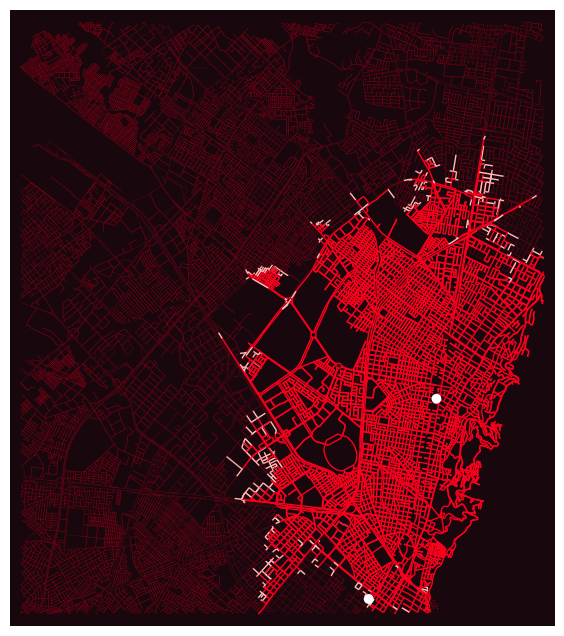

In [16]:
a_star(start, goal, heuristic = (lambda a, b: 0), plot=True, save_frames=False)

Podemos reconstruir el camino encontrado y visualizarlo:

Distance: 5.7529392911185715km
Avg. speed: 39.20634920634921km/h
Total time: 9.07835516457675min


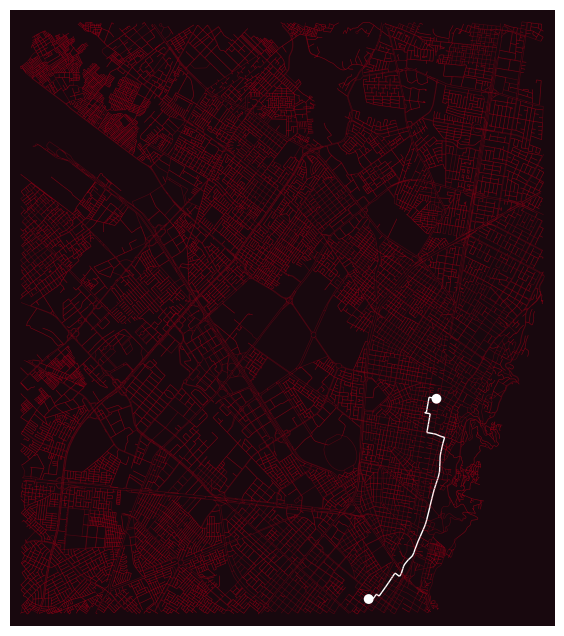

In [17]:
reconstruct_path(start, goal, plot=True, save_frames=False, algorithm="dijkstra")

#### Heurística Global (Haversine)

Ahora veamos qué pasa utilizando la heurística global `haversine_time`.

Primero veamos que esta heurística es admisible.

**Definición:** Una heurística $h(n)$ es admisible si para todo nodo $n$:
$$h(n) \leq h^*(n)$$
donde $h^*(n)$ es el costo real mínimo desde $n$ hasta el objetivo.

Recordamos que el costo real de cada arista $i$ se define como

$$w[i] = \frac{\text{longitud}[i]}{\text{velocidad}[i]}$$

que representa el tiempo de viaje en la arista $i$.

Proponemos la heurística

$$h_H(n)=\frac{\text{haversine}(n, \text{objetivo})}{\text{velocidad\_máxima}}$$

donde $\text{haversine}(x, y)$ es la distancia en línea recta (sobre la esfera terrestre) entre los nodos $x$, $y$; y $\text{velocidad\_máxima}$ es la velocidad máxima entre todas las aristas.

**Proposición:** La heurística $h_H$ es admisible.

  **Demostración:** Sea $P=\{x_1, x_2, ...,x_k\}$ un camino óptimo entre $n$ y $\text{objetivo}$. La distancia Haversine es menor o igual que cualquier ruta real en el grafo pues en geometría esférica se mantiene la desigualdad triangular:

  $$\text{haversine(n, objetivo)} \leq \sum_{i=1}^k\text{longitud[i]}$$
  
  Además, es claro que 

  $$\text{velocidad\_máxima} \geq \text{velocidad[i]}$$

  para $1\leq i \leq k$.

  Combinando ambas desigualdades,

  $$\frac{\text{haversine(n, objetivo)}}{\text{velocidad\_máxima}} \leq \sum_{i=1}^k\frac{\text{longitud[i]}}{\text{velocidad[i]}} = h^*(n).$$

  Luego la heurística nunca sobrestima el tiempo real mínimo, por lo tanto es admisible.




En este sentido, el algoritmo debe encontrar también una ruta óptima utilizando esta heurística:

Iteraciones: 2388


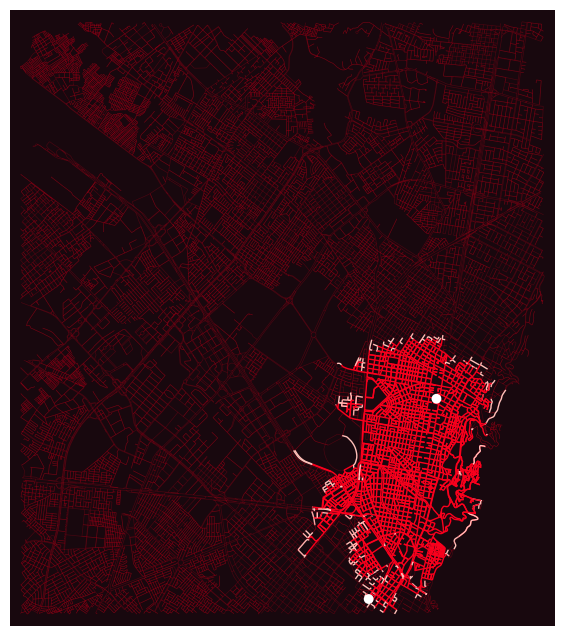

In [18]:
a_star(start, goal, haversine_time, plot=True, save_frames=False)

Distance: 5.7529392911185715km
Avg. speed: 39.20634920634921km/h
Total time: 9.07835516457675min


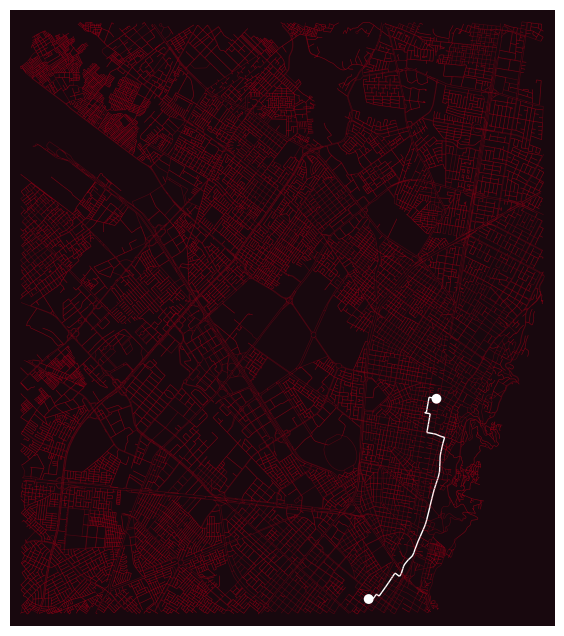

In [19]:
reconstruct_path(start, goal, plot=True, save_frames=False, algorithm="a_star_haversine")

Vemos que en efecto encuentra una ruta óptima (la misma encontrada por Dijkstra).

#### Heurística local ($\text{LoHA}^*$)